In [1]:
from functions_files import compact_keras,easy_cross_val

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.


In [2]:
from sklearn import datasets

iris = datasets.load_iris()
data = iris.data # iris data
trgt = iris.target # iris data

In [3]:
testando_v1 = easy_cross_val.easy_cross_val(max_neurons=5)

In [4]:
testando_v1.get_cross_values(data,trgt)

Processing: Fold 1 of 3 Init 1 of 2 with 1 neurons of 5
Processing: Fold 1 of 3 Init 2 of 2 with 1 neurons of 5
Processing: Fold 2 of 3 Init 1 of 2 with 1 neurons of 5
Processing: Fold 2 of 3 Init 2 of 2 with 1 neurons of 5
Processing: Fold 3 of 3 Init 1 of 2 with 1 neurons of 5
Processing: Fold 3 of 3 Init 2 of 2 with 1 neurons of 5
Processing: Fold 1 of 3 Init 1 of 2 with 2 neurons of 5
Processing: Fold 1 of 3 Init 2 of 2 with 2 neurons of 5
Processing: Fold 2 of 3 Init 1 of 2 with 2 neurons of 5
Processing: Fold 2 of 3 Init 2 of 2 with 2 neurons of 5
Processing: Fold 3 of 3 Init 1 of 2 with 2 neurons of 5
Processing: Fold 3 of 3 Init 2 of 2 with 2 neurons of 5
Processing: Fold 1 of 3 Init 1 of 2 with 3 neurons of 5
Processing: Fold 1 of 3 Init 2 of 2 with 3 neurons of 5
Processing: Fold 2 of 3 Init 1 of 2 with 3 neurons of 5
Processing: Fold 2 of 3 Init 2 of 2 with 3 neurons of 5
Processing: Fold 3 of 3 Init 1 of 2 with 3 neurons of 5
Processing: Fold 3 of 3 Init 2 of 2 with 3 neuro

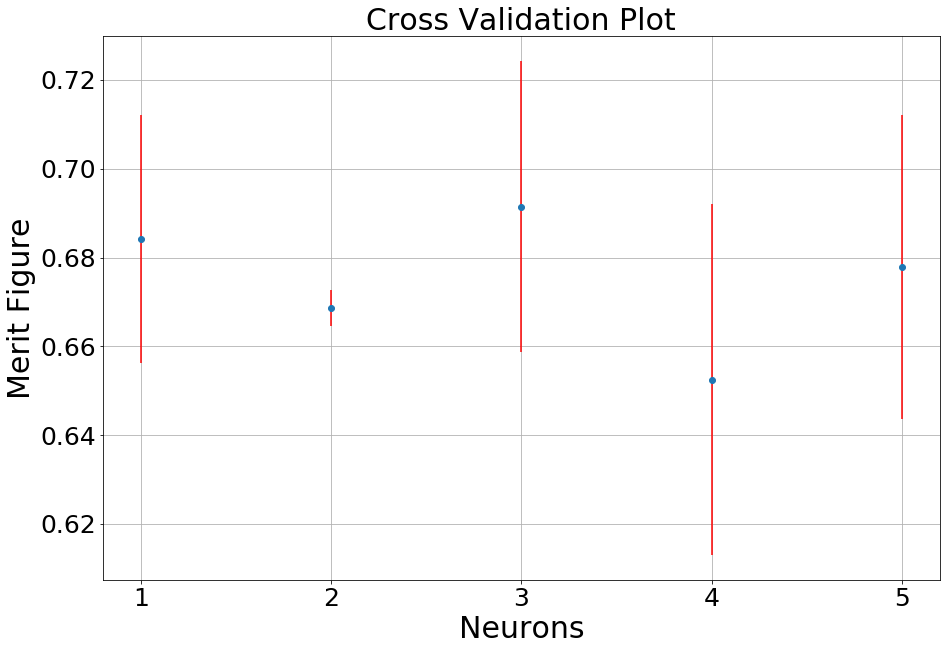

In [5]:
testando_v1.make_validation_plots(save_plot=False)

In [74]:
teste = model_selection.StratifiedKFold(n_splits=5)
indices = {}
for ((train_index, test_index),jkey) in zip(teste.split(data,trgt),range(5)):
    indices[jkey]= [train_index,test_index]
    
indices[0][1]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109])

In [5]:
import numpy as np

from sklearn import model_selection
from sklearn import preprocessing
from sklearn import datasets
from keras.utils import np_utils
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import pickle

class easy_cross_val(object):
    '''
    version -- v0.0
    easy_cross_val is a class that you can make a cross validation without use many code lines.
    
    Arguments:
    input_data -- this is the set that will be in training.
    target -- this is the set that will be the target of training.
    
    Keyword Arguments:
    n_inits -- this number give the times that your model will be initialize
    n_folds -- this number is the number of partitions that will be applied in input_data and target to make training and test set.
    max_neurons -- number max of neurons that will be used to test model.
    
                                    easy_cross_val make easy is possible:
    *==============================================================================================================*
    ||                                  Example using iris dataset:                                               ||
    ||  >>> from sklearn import datasets                                                                          ||
    ||                                                                                                            ||
    ||  >>> iris = datasets.load_iris()                                                                           ||
    ||  >>> data = iris.data # iris data                                                                          ||
    ||  >>> trgt = iris.target # iris data                                                                        ||
    ||  >>> cross_validation = easy_cross_val(max_neurons=5) # initialize the easy_cross_val                      ||
    ||  >>> cross_validation.get_cross_values(data,trgt) # get the values of cross validation                     ||
    ||  >>> cross_validation.make_validation_plots(save_plot=False)                                               ||
    *==============================================================================================================*
    '''
    def __init__(self,n_inits=2,n_folds=3,max_neurons = 3):
        self.n_inits = n_inits
        self.n_folds = n_folds
        self.n_neurons_to_test = [i+1 for i in range(max_neurons)]
        self.cross_indices = {}
        self.cross_values_scores = {}
        self.cross_models = {}
        
    
    def get_indices(self,input_data,target):
        selector = model_selection.StratifiedKFold(n_splits=self.n_folds,shuffle=True)
        
        for ((train_index, test_index),jkey) in zip(selector.split(input_data,target),range(self.n_folds)):
            self.cross_indices[jkey+1]= [train_index,test_index]
            
        return self.cross_indices
    
    
    def get_cross_values(self,input_data, target,categorial_target=True):
        self.get_indices(input_data,target)
        if categorial_target:
            trgt_sparse = np_utils.to_categorical(target)
        for ineuron in self.n_neurons_to_test:
            for ifold in range(self.n_folds):
                train_id, test_id = self.cross_indices[ifold+1]
                
                scaler = preprocessing.StandardScaler().fit(input_data[train_id,:])
                norm_data = scaler.transform(input_data)
                        
                best_init = 0
                best_acc = 0.0
                best_loss = 999
                
                for i_init in range(self.n_inits):
                    print ('Processing: Fold %i of %i Init %i of %i with %i neurons of %i'%(
                            ifold+1, self.n_folds,
                            i_init+1, self.n_inits,
                            ineuron, len(self.n_neurons_to_test)))
                    
                    model = compact_keras.Compact_Keras(input_data.shape[1],number_of_neurons=ineuron,
                                                number_neurons_output_layer=3)
                    
                    train_model = model.train(norm_data[train_id,:],trgt_sparse[train_id,:],
                                                     validation_data=(norm_data[test_id,:],trgt_sparse[test_id,:]))
                    
                    if np.max(train_model.history['val_acc']) > best_acc:
                        best_init = i_init
                        best_acc = np.min(train_model.history['val_acc'])
                        self.cross_values_scores[ineuron] = train_model
                        self.cross_models[ineuron] = model
            
    def make_validation_plots(self,save_plot=True,save_path='',save_name=''):
        mean_values = [np.mean(self.cross_values_scores[ineuron].history['val_acc']) for ineuron in self.n_neurons_to_test]
        rms_values = [np.std(self.cross_values_scores[ineuron].history['val_acc']) for ineuron in self.n_neurons_to_test]
        fig, ax = plt.subplots(1,figsize=(15,10))
        plt.errorbar(self.n_neurons_to_test,mean_values, yerr = rms_values,ecolor='r',fmt = 'o',capthick=5)
        plt.title('Cross Validation Plot',fontsize=30)
        plt.xlabel('Neurons',fontsize=30)
        plt.ylabel('Merit Figure',fontsize=30)
        plt.xticks(fontsize=25)
        plt.yticks(fontsize=25)
        plt.grid()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        if save_plot:
            plt.savefig(save_path+'/'+save_name+'.png')
        plt.show()

In [20]:
testando = easy_cross_val(max_neurons=5)

In [21]:
testando.get_cross_values(data,trgt)

Processing: Fold 1 of 3 Init 1 of 2 with 1 neurons of 5
Processing: Fold 1 of 3 Init 2 of 2 with 1 neurons of 5
Processing: Fold 2 of 3 Init 1 of 2 with 1 neurons of 5
Processing: Fold 2 of 3 Init 2 of 2 with 1 neurons of 5
Processing: Fold 3 of 3 Init 1 of 2 with 1 neurons of 5
Processing: Fold 3 of 3 Init 2 of 2 with 1 neurons of 5
Processing: Fold 1 of 3 Init 1 of 2 with 2 neurons of 5
Processing: Fold 1 of 3 Init 2 of 2 with 2 neurons of 5
Processing: Fold 2 of 3 Init 1 of 2 with 2 neurons of 5
Processing: Fold 2 of 3 Init 2 of 2 with 2 neurons of 5
Processing: Fold 3 of 3 Init 1 of 2 with 2 neurons of 5
Processing: Fold 3 of 3 Init 2 of 2 with 2 neurons of 5
Processing: Fold 1 of 3 Init 1 of 2 with 3 neurons of 5
Processing: Fold 1 of 3 Init 2 of 2 with 3 neurons of 5
Processing: Fold 2 of 3 Init 1 of 2 with 3 neurons of 5
Processing: Fold 2 of 3 Init 2 of 2 with 3 neurons of 5
Processing: Fold 3 of 3 Init 1 of 2 with 3 neurons of 5
Processing: Fold 3 of 3 Init 2 of 2 with 3 neuro

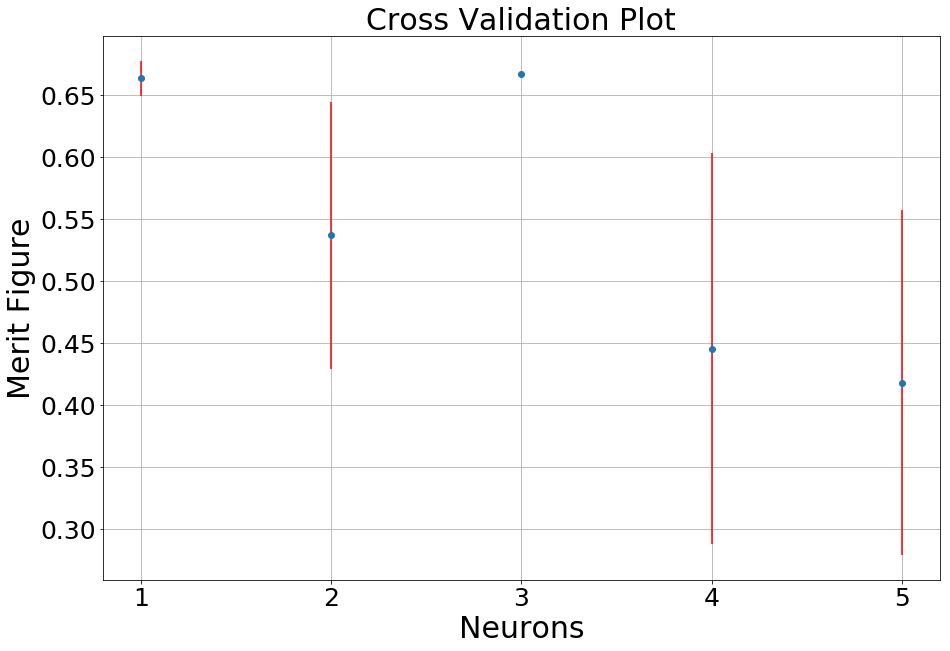

In [22]:
testando.make_validation_plots(save_plot=False)